# Perception
- input: obstacle position (x, y)
- output: NIG parameters of x, y

In [12]:
!pwd
!export PYTHONPATH=$PYTHONPATH:$(pwd)/evidential-learning-pytorch

import sys
print(sys.path)
sys.path.append('/work/DRO-EDL/1d/evidential-learning-pytorch')

from tqdm import tqdm
from scipy.stats import norm

import numpy as np
from scipy.stats import norm, invgamma

import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import minimize
from scipy.integrate import dblquad

import torch

from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from edl_pytorch import NormalInvGamma, evidential_regression

import torch.optim as optim

from scipy.stats import invgamma, norm

/work/DRO-EDL/2d
['/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/opencda/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/work/dro/temp/1d/evidential-learning-pytorch']


In [13]:
def cart2polar(x,y):
    r = (x**2 + y**2)**(1/2)
    theta = np.arctan2(y,x)
    return r , theta

def polar2cart(r,theta):
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x,y

In [14]:
torch.manual_seed(0)

model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    NormalInvGamma(64, 2),
)
model.load_state_dict(torch.load(f'uncertain_weights/{90}.pth', weights_only=True))


<All keys matched successfully>

In [15]:
def NIG_sample(params):
    mu_0, lambda_, alpha, beta = params
    x_sigma2_dist = invgamma(alpha, scale=beta)
    sigma2 = x_sigma2_dist.rvs(1)
    x_mu_dist = norm(mu_0, np.sqrt(sigma2 / lambda_))
    mu = x_mu_dist.rvs(1)
    return np.array([mu[0], sigma2[0]])

In [77]:
import pickle
target_cdf = 0.9
a_memory = dict()
with open(f'../a_memory_sets/a_memory_{target_cdf}.pickle', 'rb') as f:
    a_memory = pickle.load(f)

In [78]:
from matplotlib.patches import Polygon
from ipywidgets import interact, FloatSlider

def plot(x, y):
    fig, ax = plt.subplots(figsize=(8,8))
    
    sample = [x, y]
    input_data = torch.tensor(cart2polar(*sample), dtype=torch.float)[None,:]
    with torch.no_grad():
        pred = model(input_data)
    x_params = [pred[0][0,0], pred[1][0,0], pred[2][0,0], pred[3][0,0]]
    y_params = [pred[0][0,1], pred[1][0,1], pred[2][0,1], pred[3][0,1]]

    
    # ambiguity set
    ## x axis
    mu_0, lambda_, alpha, beta = x_params
    try:
        x_mu_low, x_mu_high, x_sigma2_low, x_sigma2_high = a_memory[float(f'{alpha:.02f}')]
    except:
        x_mu_low, x_mu_high, x_sigma2_low, x_sigma2_high = a_memory[float(f'{1.01}')]
    
    ## y axis
    mu_0, lambda_, alpha, beta = y_params
    try:
        y_mu_low, y_mu_high, y_sigma2_low, y_sigma2_high = a_memory[float(f'{alpha:.02f}')]
    except:
        y_mu_low, y_mu_high, y_sigma2_low, y_sigma2_high = a_memory[float(f'{1.01}')]
    
    vertices = [(x_mu_low, y_mu_low), (x_mu_low, y_mu_high), (x_mu_high, y_mu_high), (x_mu_high, y_mu_low)]
    
    rectangle = Polygon(vertices, closed=True, color='red')
    # sampling
    for _ in range(500):
        x_dist_params = NIG_sample(x_params)
        y_dist_params = NIG_sample(y_params)

        mean = np.array([x_dist_params[0], y_dist_params[0]])
        cov = np.array([
            [x_dist_params[1], 0],
            [0, y_dist_params[1]]
        ])


        # 공분산 행렬의 고유값과 고유벡터 계산
        eigvals, eigvecs = np.linalg.eigh(cov)

        # 1-sigma 수준에서 타원의 축 반지름 계산
        axis_lengths = np.sqrt(eigvals)

        # 타원의 각도 계산 (라디안)
        angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])

        # 타원 좌표 생성
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse = np.array([axis_lengths[0] * np.cos(theta), axis_lengths[1] * np.sin(theta)])

        # 타원의 회전 적용
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                     [np.sin(angle), np.cos(angle)]])
        rotated_ellipse = rotation_matrix @ ellipse

        # 타원을 평균 좌표로 이동
        ellipse_x, ellipse_y = rotated_ellipse[0] + mean[0], rotated_ellipse[1] + mean[1]
        if (x_mu_low < mean[0] and mean[0] < x_mu_high) and (y_mu_low < mean[1] and mean[1] < y_mu_high):
            color = 'lime'
            alpha = 0.1
            label = 'in ambiguity set'
        else:
            color = 'skyblue'
            alpha = 0.8
            label = 'out of ambiguity set'
        plt.plot(ellipse_x, ellipse_y, color=color, alpha=alpha, label=label)
    ax.add_patch(rectangle)

    plt.scatter(*sample, color='g', label='Ground Truth')
    plt.xlim(-100, 100)
    plt.ylim(-100, 100)
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # 중복 제거

    # 고유한 레이블만 포함하는 legend 표시
    plt.legend(unique_labels.values(), unique_labels.keys())   
    plt.show()


interact(
        plot,
        x=FloatSlider(min=-100, max=100, step=1, value=0, description='Major Axis (a)'),
        y=FloatSlider(min=-100, max=100, step=1, value=0, description='Minor Axis (b)'),
);


interactive(children=(FloatSlider(value=0.0, description='Major Axis (a)', min=-100.0, step=1.0), FloatSlider(…

In [19]:
sample_list = list()
for i in range(50):
    sample_list.append([-i, 0])
    
for i in range(50):
    sample_list.append([-50, i])
    
for i in range(100):
    sample_list.append([i-50, 50])
    
for i in range(100):
    sample_list.append([50, 50-i])
    
for i in range(150):
    sample_list.append([50-i, -50])
    
for i in range(150):
    sample_list.append([-100, i-50])
    
for i in range(200):
    sample_list.append([i-100, 100])
    
for i in range(200):
    sample_list.append([100, i-100])

0it [00:00, ?it/s]

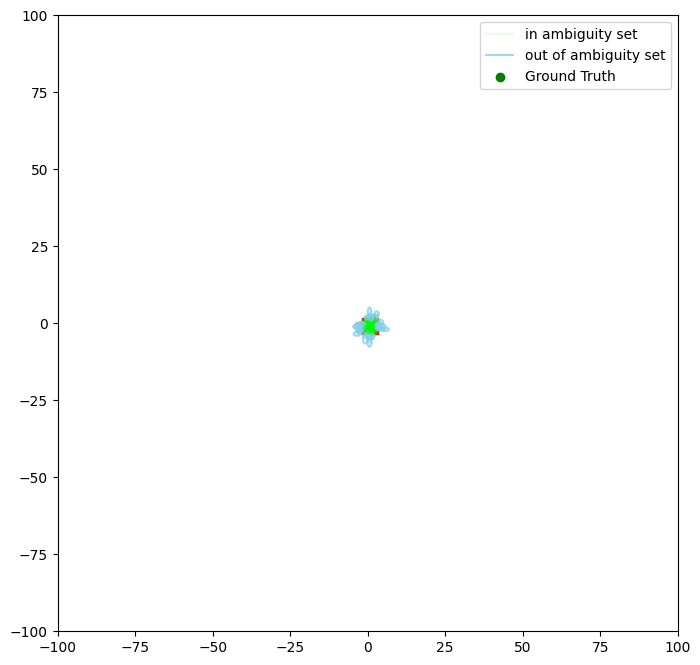

0it [00:00, ?it/s]


In [20]:
from matplotlib.patches import Polygon
from ipywidgets import interact, FloatSlider
from tqdm import tqdm

for idx, (x,y) in tqdm(enumerate(sample_list)):
    fig, ax = plt.subplots(figsize=(8,8))
    
    sample = [x, y]
    input_data = torch.tensor(cart2polar(*sample), dtype=torch.float)[None,:]
    with torch.no_grad():
        pred = model(input_data)
    x_params = [pred[0][0,0], pred[1][0,0], pred[2][0,0], pred[3][0,0]]
    y_params = [pred[0][0,1], pred[1][0,1], pred[2][0,1], pred[3][0,1]]

    
    # ambiguity set
    ## x axis
    mu_0, lambda_, alpha, beta = x_params
    try:
        zx, zy = a_memory[float(f'{alpha:.02f}')]
    except:
        zx, zy = a_memory[float(f'{1.01}')]
    delta = zx / np.sqrt(lambda_/beta)
    x_mu_low, x_mu_high = mu_0 - delta, mu_0 + delta
    
    ## y axis
    mu_0, lambda_, alpha, beta = y_params
    try:
        zx, zy = a_memory[float(f'{alpha:.02f}')]
    except:
        zx, zy = a_memory[float(f'{1.01}')]
    delta = zx / np.sqrt(lambda_/beta)
    y_mu_low, y_mu_high = mu_0 - delta, mu_0 + delta
    
    vertices = [(x_mu_low, y_mu_low), (x_mu_low, y_mu_high), (x_mu_high, y_mu_high), (x_mu_high, y_mu_low)]
    
    rectangle = Polygon(vertices, closed=True, color='red')
    # sampling
    for _ in range(500):
        x_dist_params = NIG_sample(x_params)
        y_dist_params = NIG_sample(y_params)

        mean = np.array([x_dist_params[0], y_dist_params[0]])
        cov = np.array([
            [x_dist_params[1], 0],
            [0, y_dist_params[1]]
        ])


        # 공분산 행렬의 고유값과 고유벡터 계산
        eigvals, eigvecs = np.linalg.eigh(cov)

        # 1-sigma 수준에서 타원의 축 반지름 계산
        axis_lengths = np.sqrt(eigvals)

        # 타원의 각도 계산 (라디안)
        angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])

        # 타원 좌표 생성
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse = np.array([axis_lengths[0] * np.cos(theta), axis_lengths[1] * np.sin(theta)])

        # 타원의 회전 적용
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                     [np.sin(angle), np.cos(angle)]])
        rotated_ellipse = rotation_matrix @ ellipse

        # 타원을 평균 좌표로 이동
        ellipse_x, ellipse_y = rotated_ellipse[0] + mean[0], rotated_ellipse[1] + mean[1]
        if (x_mu_low < mean[0] and mean[0] < x_mu_high) and (y_mu_low < mean[1] and mean[1] < y_mu_high):
            color = 'lime'
            alpha = 0.1
            label = 'in ambiguity set'
        else:
            color = 'skyblue'
            alpha = 0.8
            label = 'out of ambiguity set'
        plt.plot(ellipse_x, ellipse_y, color=color, alpha=alpha, label=label)
    ax.add_patch(rectangle)

    plt.scatter(*sample, color='g', label='Ground Truth')
    plt.xlim(-100, 100)
    plt.ylim(-100, 100)
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # 중복 제거

    # 고유한 레이블만 포함하는 legend 표시
    plt.legend(unique_labels.values(), unique_labels.keys())   
    plt.show()
    break


# Make surrogate ambiguity set
- input: NIG pararmeters of x, y
- output: surrogate ambiguity set 
    - example:  
    $\mu: [\mu_{min}, \mu_{max}]$  
               $\sigma^2: [\sigma_{min}^2, \sigma_{max}^2]$

# Make a contraint
- input: (surrogate) ambiguity set
- output: 
    1. worst case perception distribution $(\mu, \Sigma)$
    2. calculate the constraint (worst case CVaR(loss))
    
    


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, foldnorm

In [6]:
def plot_ellipse(mean, covariance, n_std=2, ax=None, **kwargs):
    """
    평균과 공분산 행렬을 사용하여 타원을 그립니다.

    Parameters:
    - mean: 1x2 배열, 타원의 중심 (평균 벡터)
    - covariance: 2x2 배열, 공분산 행렬
    - n_std: float, 타원의 크기를 결정하는 표준편차의 배수 (기본값: 2)
    - ax: matplotlib 축 객체 (기본값: None)
    - kwargs: matplotlib.patches.Ellipse에 전달할 추가 스타일 인수

    Returns:
    - 타원을 그린 matplotlib Ellipse 객체
    """
    from matplotlib.patches import Ellipse
    if ax is None:
        ax = plt.gca()

    # 공분산 행렬의 고유값과 고유벡터 계산
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)

    # 고유값의 제곱근으로 타원의 축 길이 결정
    axis_length = n_std * np.sqrt(eigenvalues)

    # 고유벡터에서 타원의 회전 각도 계산
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # 타원 생성
    ellipse = Ellipse(
        xy=mean,
        width=2 * axis_length[0],
        height=2 * axis_length[1],
        angle=angle,
        **kwargs
    )

    # 타원을 플롯에 추가
    ax.add_patch(ellipse)

    return ellipse

In [7]:
mu_x_list = np.linspace(14, 18, 100)
mu_y_list = np.linspace(11, 16, 100)

sigma_x_list = np.linspace(0.4, 1, 100)
sigma_y_list = np.linspace(0.9, 3, 100)

In [8]:
mu_x_samples = np.random.uniform(14, 18, 100)
mu_y_samples = np.random.uniform(11, 16, 100)

sigma_x_samples = np.random.uniform(0.4, 1, 100)
sigma_y_samples = np.random.uniform(0.9, 3, 100)

mu_samples = np.stack([mu_x_samples, mu_y_samples])

z = np.zeros_like(sigma_x_samples)
Sigma = np.stack([sigma_x_samples, z, z, sigma_y_samples])
Sigma_samples = Sigma.reshape(2,2,-1)

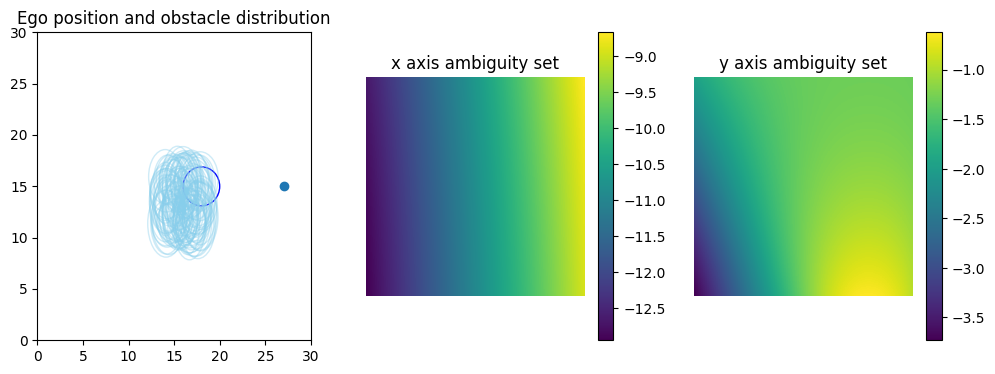

In [10]:
from ipywidgets import interact, IntSlider
R = 12
for fig_idx, theta in enumerate(range(360)):
    theta = theta / 180 * np.pi
    point = [R * np.cos(theta) + 15, R * np.sin(theta) + 15]

    fig, ax = plt.subplots(1,3,figsize=(12, 4))

    # x CVaR fill
    mu_x_grid, sigma_x_grid = np.meshgrid(mu_x_list, sigma_x_list)
    params = np.stack([mu_x_grid.flatten(), sigma_x_grid.flatten()])

    x_CVaR_values = np.zeros([100, 100]).flatten()

    for idx, (mu, sigma) in enumerate(params.T):
        diff_mu = abs(mu - point[0])
        diff_sigma = sigma
        d_dist = foldnorm(diff_mu / diff_sigma, scale=diff_sigma)
        mean, std = d_dist.stats()
        epsilon = 0.1
        kappa = np.sqrt(epsilon / (1-epsilon))
        CVaR = -mean + kappa * std
        x_CVaR_values[idx] = CVaR
    
    x_CVaR_values = x_CVaR_values.reshape(100, 100)
    highlight_mu_x, highlight_sigma_x = params[:,x_CVaR_values.argmax()]

    # y CVaR fill
    mu_y_grid, sigma_y_grid = np.meshgrid(mu_y_list, sigma_y_list)
    params = np.stack([mu_y_grid.flatten(), sigma_y_grid.flatten()])

    y_CVaR_values = np.zeros([100, 100]).flatten()

    for idx, (mu, sigma) in enumerate(params.T):
        diff_mu = abs(mu - point[1])
        diff_sigma = sigma
        d_dist = foldnorm(diff_mu / diff_sigma, scale=diff_sigma)
        mean, std = d_dist.stats()
        epsilon = 0.1
        kappa = np.sqrt(epsilon / (1-epsilon))
        CVaR = -mean + kappa * std
        y_CVaR_values[idx] = CVaR
       
    y_CVaR_values = y_CVaR_values.reshape(100, 100)
    highlight_mu_y, highlight_sigma_y = params[:,y_CVaR_values.argmax()]
    
    mu = [highlight_mu_x, highlight_mu_y]
    Sigma = [
        [highlight_sigma_x, 0],
        [0, highlight_sigma_y]
    ]
    plot_ellipse(mu, Sigma, n_std=2, ax=ax[0], color='blue', fill=False)

    
    
    
    
    cax = ax[1].imshow(x_CVaR_values)
    ax[1].invert_yaxis()
    ax[1].set_title('x axis ambiguity set')
    ax[1].axis('off')
    fig.colorbar(cax)
    
    cax = ax[2].imshow(y_CVaR_values)
    ax[2].invert_yaxis()
    ax[2].set_title('y axis ambiguity set')
    ax[2].axis('off')
    fig.colorbar(cax)
    
    ax[0].set_xlim(0, 30)
    ax[0].set_ylim(0, 30)
    
    for mu, Sigma in zip(mu_samples.T, Sigma_samples.T):
        plot_ellipse(mu, Sigma, n_std=2, ax=ax[0], color='skyblue', fill=False, alpha=0.4)
    ax[0].scatter(*point)
    ax[0].set_title('Ego position and obstacle distribution')
    plt.show()
    break

# Aggregate all modules
1. EDL perception model
2. make a surrogate ambiguity set
3. find a worst case perception and calculate the constraint

In [21]:
torch.manual_seed(0)

model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    NormalInvGamma(64, 2),
)
model.load_state_dict(torch.load(f'uncertain_weights/{90}.pth', weights_only=True))


<All keys matched successfully>

## 1. EDL perception model

In [88]:
def perception(model, obstacle_position):
    '''
    input:
    - perception model: torch NN
    - obstacle vehicle's potision: [x, y]
    
    output:
    - obstacle vehicle's perception NIG distribution params for each axis [[mu_0_x, lambda_x, alpha_x, beta_x], [mu_0_y, lambda_y, alpha_y, beta_y]]
    '''

    obstacle_observation = cart2polar(*obstacle_position)

    input_data = torch.tensor(obstacle_observation, dtype=torch.float)[None,:]
    with torch.no_grad():
        pred = model(input_data)

    x_params = [pred[0][0,0], pred[1][0,0], pred[2][0,0], pred[3][0,0]]
    y_params = [pred[0][0,1], pred[1][0,1], pred[2][0,1], pred[3][0,1]]
    
    return [x_params, y_params]


In [89]:

obstacle_position = [30, 40]

perception(model, obstacle_position)


[[tensor(28.3763), tensor(0.5194), tensor(1.6327), tensor(4.4633)],
 [tensor(40.3058), tensor(0.8530), tensor(2.3585), tensor(4.2729)]]

## 2. make a surrogate ambiguity set
- 기존에는 우측 상단의 mu_max, sigma2_max 점 하나만 메모리에 저장해 두었는데
- 이제는 좌우 위아래 꼭짓점 다 저장하는걸로 하자..!
- 그러고 나중에 호출할 때는 4개의 점을 받아서 다시 되돌리는걸로

In [105]:
def create_surrogate_ambiguity_set(params):
    '''
    params: [mu_0, lambda_, alpha, beta]
    '''
    mu_0, labmda_, alpha, beta = params
    try:
        mu_low, mu_high, sigma2_low, sigma2_high = a_memory[float(f'{alpha:.02f}')]
    except:
        mu_low, mu_high, sigma2_low, sigma2_high = a_memory[float(f'{1.01}')]

        
    mu_low = mu_low / np.sqrt(lambda_/beta) + mu_0
    mu_high = mu_high / np.sqrt(lambda_/beta) + mu_0
    sigma2_low = sigma2_low * beta
    sigma2_high = sigma2_high * beta
    return mu_low, mu_high, sigma2_low, sigma2_high

In [80]:
x_ambiguity_set = create_surrogate_ambiguity_set(x_params)
y_ambiguity_set = create_surrogate_ambiguity_set(y_params)


# x_mu_low, x_mu_high, x_sigma2_low, x_sigma2_high = create_surrogate_ambiguity_set(x_params)
# y_mu_low, y_mu_high, y_sigma2_low, y_sigma2_high = create_surrogate_ambiguity_set(y_params)

# vertices = [(x_mu_low, y_mu_low), (x_mu_low, y_mu_high), (x_mu_high, y_mu_high), (x_mu_high, y_mu_low)]
    
# rectangle = Polygon(vertices, closed=True, color='red')

# fig, ax = plt.subplots()
# ax.add_patch(rectangle)
# ax.set_xlim(-100, 100)
# ax.set_ylim(-100, 100)
# plt.show()

## 3. find a worst case perception and calculate the constraint

In [81]:
def get_DRO_solution(ambiguity_set, ego_position):
    '''
    ambiguity set: parameter ranges [mu_low, mu_high, sigma2_low, sigma2_high]
    ego position: ego vehicle's position [x] (calculate for each axis)
    
    일단은 2가지 경우로 하고,
    나중에 3가지 경우로 중간에 애매한 위치일 경우 sigma2를 바꾸는걸로 고치자
    '''
    mu_low, mu_high, sigma2_low, sigma2_high = ambiguity_set
    
    if mu_low <= ego_position <= mu_high:
        # 안에 포함됨
        mu = ego_position
        sigma2 = sigma2_low
    elif ego_position < mu_low:
        # 왼쪽에 떨어져 있음
        mu = mu_low
        sigma2 = sigma2_high
    
    else: # ego_position > mu_high
        # 오른쪽에 가까이 있음
        mu = mu_high
        sigma2 = sigma2_high
        
    return mu, sigma2

In [82]:
x_worst_case_perception = get_DRO_solution(x_ambiguity_set, ego_position[0])
y_worst_case_perception = get_DRO_solution(y_ambiguity_set, ego_position[1])

x_mu, x_sigma2 = x_worst_case_perception
y_mu, y_sigma2 = y_worst_case_perception
worst_case_perception = ([x_mu, y_mu], [[x_sigma2, 0], [0, y_sigma2]])

# Calculate the worst case CVaR
- use Unscented Transform to calculate the loss

In [129]:
def Unscented_Transform(dist, ego_position):
    '''
    input
    - dist: perception distribution
    - ego_position: ego vehicle's position (for loss calculation)

    output
    - loss_dist: loss distance distribution
    '''

    mu, Sigma = dist
    mu = torch.tensor(mu, dtype=torch.float)[None,:]
    Sigma = torch.tensor(Sigma, dtype=torch.float)[None, :,:]
    # cholesky matrix
    chol_matrices = torch.linalg.cholesky(Sigma)

    # UT params
    alpha = 1e-3
    beta = 2.0
    kappa = 0.0
    n = mu.shape[1]
    lambda_ = torch.tensor(alpha**2 * (n + kappa) - n, dtype=torch.float)

    # Compute weights
    Wm = torch.full((2 * n + 1,), 1 / (2 * (n + lambda_)))  # Mean weights
    Wm[0] = lambda_ / (n + lambda_)

    Wc = Wm.clone()  # Covariance weights
    Wc[0] += 1 - alpha**2 + beta

    # Generate sigma points for the entire batch
    scaling = torch.sqrt(n + lambda_)
    sigma_points = []

    # Central sigma points
    sigma_points.append(mu)

    # Positive and negative directions
    for i in range(n):
        sigma_points.append(mu + scaling * chol_matrices[:, :, i])
        sigma_points.append(mu - scaling * chol_matrices[:, :, i])

    # Stack sigma points into a batch tensor
    sigma_points = torch.stack(sigma_points, dim=1)  # Shape: (batch, 2n+1, n)

    def nonlinear_transform(obs_position, ego_position):
        target = torch.tensor(ego_position)  # Point (3, 4)
        distance = 10-torch.sqrt(torch.sum((obs_position - target)**2, dim=-1))  # Euclidean distance
        return distance  # Add last dimension for compatibility


    transformed_sigma_points = nonlinear_transform(sigma_points, ego_position)

    # Compute transformed means (batch)
    transformed_means = torch.sum(Wm[None, :] * transformed_sigma_points, dim=1)

    # Compute transformed covariances (batch)
    diff = transformed_sigma_points - transformed_means[:, None]
    transformed_variances = torch.sum(Wc[None, :] * diff**2, dim=1)#torch.einsum('bij,bi,bik->bjk', diff, Wc[None], diff)

    transformed_std = torch.sqrt(transformed_variances)

    return transformed_means, transformed_std

In [84]:
Unscented_Transform(worst_case_perception, [4,5])

torch.Size([1, 2, 2])


(tensor([2.4375]), tensor([1.7567]))

In [85]:
def calculate_CVaR(dist, ego_position):
    '''
    input:
    - dist: worst case multivariate normal distribution ([mu_x, Mu_y], [[sigma2_x, 0], [0, sigma2_y]])
    - ego_position: ego vehicle's position for loss computation
    
    '''
    loss_mu, loss_sigma = Unscented_Transform(dist, ego_position)
    loss_dist = norm(loss_mu, scale=loss_sigma)
    
    epsilon = 0.95
    target_cdf = 0.50
    kappa = norm.pdf(norm.ppf(epsilon))/(1-epsilon)
    loss_CVaR = loss_mu + kappa * loss_sigma
    
    return loss_CVaR

In [86]:
calculate_CVaR(worst_case_perception, [4,5])

torch.Size([1, 2, 2])


tensor([6.0610])

# Visualize

In [109]:
def plot(observation_x, observation_y, ego_x, ego_y):
    obstacle = [observation_x, observation_y]
    ego_position = [ego_x, ego_y]
    fig, ax = plt.subplots()
    
    # EDL perception
    x_params, y_params = perception(model, obstacle)

    # make surrogate ambiguity set
    x_ambiguity_set = create_surrogate_ambiguity_set(x_params)
    y_ambiguity_set = create_surrogate_ambiguity_set(y_params)
    
    x_mu_low, x_mu_high, _, _ = x_ambiguity_set
    y_mu_low, y_mu_high, _, _ = y_ambiguity_set
    
    vertices = [(x_mu_low, y_mu_low), (x_mu_low, y_mu_high), (x_mu_high, y_mu_high), (x_mu_high, y_mu_low)]
    
    rectangle = Polygon(vertices, closed=True, color='red')
    ax.add_patch(rectangle)

    # get DRO solution
    x_worst_case_perception = get_DRO_solution(x_ambiguity_set, ego_position[0])
    y_worst_case_perception = get_DRO_solution(y_ambiguity_set, ego_position[1])

    x_mu, x_sigma2 = x_worst_case_perception
    y_mu, y_sigma2 = y_worst_case_perception
    worst_case_perception = ([x_mu, y_mu], [[x_sigma2, 0], [0, y_sigma2]])

    worst_mu, worst_Sigma = worst_case_perception
    
    plot_ellipse(worst_mu, worst_Sigma, n_std=2, ax=ax, color='skyblue', fill=False, alpha=1)

    CVaR = calculate_CVaR(worst_case_perception, ego_position)
    
    ax.scatter(observation_x, observation_y, color='b', label='Obstacle vehicle')
    ax.scatter(ego_x, ego_y, color='g', label='Ego vehicle')
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    ax.grid(True)
    plt.legend()
    plt.title(f"Worst Case CVaR: {CVaR}")
    plt.show()
interact(
        plot,
        observation_x=FloatSlider(min=-100, max=100, step=1, value=0, description='Major Axis (a)'),
        observation_y=FloatSlider(min=-100, max=100, step=1, value=0, description='Minor Axis (b)'),
        ego_x=FloatSlider(min=-100, max=100, step=1, value=0, description='Minor Axis (b)'),
        ego_y=FloatSlider(min=-100, max=100, step=1, value=0, description='Minor Axis (b)'),
);

interactive(children=(FloatSlider(value=0.0, description='Major Axis (a)', min=-100.0, step=1.0), FloatSlider(…

# Heatmap Visualization (like a safe barrier)

In [145]:
def plot(observation_x, observation_y):
    obstacle = [observation_x, observation_y]
    fig, ax = plt.subplots()
    
    # EDL perception
    x_params, y_params = perception(model, obstacle)

    # make surrogate ambiguity set
    x_ambiguity_set = create_surrogate_ambiguity_set(x_params)
    y_ambiguity_set = create_surrogate_ambiguity_set(y_params)
    
    x_mu_low, x_mu_high, _, _ = x_ambiguity_set
    y_mu_low, y_mu_high, _, _ = y_ambiguity_set
    
    vertices = [(x_mu_low, y_mu_low), (x_mu_low, y_mu_high), (x_mu_high, y_mu_high), (x_mu_high, y_mu_low)]
    
    # rectangle = Polygon(vertices, closed=True, color='pink', alpha=0.1)
    # ax.add_patch(rectangle)

    grid_N = 100
    ego_x_list = np.linspace(-100, 100, grid_N)
    ego_y_list = np.linspace(-100, 100, grid_N)
    
    ego_x_grid, ego_y_grid = np.meshgrid(ego_x_list, ego_y_list)
    
    ego_list = np.stack([ego_x_grid.flatten(), ego_y_grid.flatten()])
    CVaR_heatmap = np.zeros((grid_N, grid_N)).flatten()
    for ego_idx, ego_position in enumerate(ego_list.T):
        # get DRO solution
        x_worst_case_perception = get_DRO_solution(x_ambiguity_set, ego_position[0])
        y_worst_case_perception = get_DRO_solution(y_ambiguity_set, ego_position[1])

        x_mu, x_sigma2 = x_worst_case_perception
        y_mu, y_sigma2 = y_worst_case_perception
        worst_case_perception = ([x_mu, y_mu], [[x_sigma2, 0], [0, y_sigma2]])

        worst_mu, worst_Sigma = worst_case_perception

        # plot_ellipse(worst_mu, worst_Sigma, n_std=2, ax=ax, color='skyblue', fill=False, alpha=1)

        CVaR = calculate_CVaR(worst_case_perception, ego_position)
        CVaR_heatmap[ego_idx] = CVaR
        
    CVaR_heatmap = CVaR_heatmap.reshape(grid_N, grid_N)
    
    ax.scatter(observation_x, observation_y, color='b', label='Obstacle vehicle')
    col = ax.imshow(np.flipud(CVaR_heatmap), extent=(-100, 100, -100, 100), cmap='coolwarm')
    col.set_clim(-100, 100)
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    ax.grid(True)
    fig.colorbar(col)
    plt.legend()
    plt.title(f"Worst Case CVaR: {CVaR.item()}")
    plt.show()
interact(
        plot,
        observation_x=FloatSlider(min=-100, max=100, step=1, value=0, description='Major Axis (a)'),
        observation_y=FloatSlider(min=-100, max=100, step=1, value=0, description='Minor Axis (b)'),
);

interactive(children=(FloatSlider(value=0.0, description='Major Axis (a)', min=-100.0, step=1.0), FloatSlider(…

In [147]:
torch.tensor(1).item()

1